# Objective 
Predict sentiment of financial statements using various models and compare the results.
Dataset - https://www.kaggle.com/datasets/sbhatti/financial-sentiment-analysis

Using FinBERT, TF-IDF with classfifier, LSTM and BERT

In [29]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix,accuracy_score,roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import WordNetLemmatizer
from gensim.models import KeyedVectors
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn.model_selection import StratifiedKFold
from keras.layers.embeddings import Embedding
from keras.models import Model
import string
import re
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.sequence import pad_sequences
import keras
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import catboost as cbt
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import metrics
from sklearn import pipeline
from keras.preprocessing import sequence, text
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.utils import np_utils
import tensorflow as tf
from keras.callbacks import EarlyStopping
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB
import seaborn as sns

In [30]:
data_pth = '/kaggle/input/financial-sentiment-analysis/data.csv'
df = pd.read_csv(data_pth)
df.head()
target_map = {'neutral':2,'positive':0,'negative':1}
df['target'] = df['Sentiment'].map(target_map)
df.head()

,Sentence,Sentiment,target
0,The GeoSolutions technology will leverage Bene...,positive,0
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,1
2,"For the last quarter of 2010 , Componenta 's n...",positive,0
3,According to the Finnish-Russian Chamber of Co...,neutral,2
4,The Swedish buyout firm has sold its remaining...,neutral,2


In [31]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df, title="Financial Sentiment Analysis")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/16 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

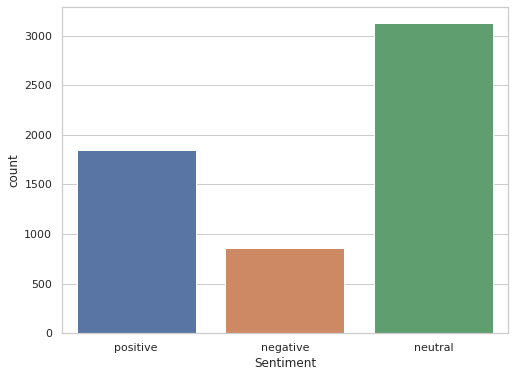

In [32]:
sns.countplot(x=df.Sentiment);

In [33]:
import torch
from transformers import AutoTokenizer, BertForSequenceClassification,AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert',padding=True,truncation=True)
model =  AutoModelForSequenceClassification.from_pretrained('ProsusAI/finbert')

Downloading:   0%|          | 0.00/252 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/758 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

In [34]:
X,y = df['Sentence'].values,df['target'].values
train_X,test_X,train_y,test_y = train_test_split(X,y,test_size=0.2,random_state=42)
print(len(train_X),len(train_y))
print(len(test_X),len(test_y))

pipe = Pipeline(steps=[
    ('tfidf',TfidfVectorizer(tokenizer=word_tokenize,max_features=200,stop_words='english')),
    ('svm',SVC(kernel='rbf'))
])

custom_model = pipe.fit(train_X,train_y)

4673 4673
1169 1169


In [35]:
def predict_bert(text):
    inputs = tokenizer(text,return_tensors='pt',add_special_tokens=True)
    res = 0
    with torch.no_grad():
        logits = model(**inputs).logits
        res = np.argmax(logits.numpy()[0])
    return res


def predict_svm(text):
    pred = custom_model.predict(text)
    return pred

def process_text(text):
    
    text = word_tokenize(text)
    text = [re.sub('[^A-Za-z]+', '', word) for word in text]
    text = [word.lower() for word in text if word.isalpha()]
    text = [WordNetLemmatizer().lemmatize(word) for word in text]
    text = ' '.join(text)
    return text

In [36]:
bert_preds = [predict_bert(s) for s in test_X]
bert_acc = accuracy_score(test_y,bert_preds)

svm_preds = predict_svm(test_X)
svm_acc = accuracy_score(test_y,svm_preds)

print('-------------------- Accuracy Scores ----------------------------')
# print(f'TextBlob : {textblob_acc}')
# print(f'Vader : {vader_acc}')
print(f'FinBert : {bert_acc}')
print(f'SVM : {svm_acc}')

-------------------- Accuracy Scores ----------------------------
FinBert : 0.7630453378956373
SVM : 0.6869118905047049


In [37]:
dicto = {'positive': 1, 'neutral': 0 , 'negative': -1}

df.Sentiment = df.Sentiment.map(dicto)

In [38]:
word2vec_pretrained = KeyedVectors.load_word2vec_format("../input/googles-trained-word2vec-model-in-python/GoogleNews-vectors-negative300.bin",binary=True)
word2vec_pretrained_dict = dict(zip(word2vec_pretrained.key_to_index.keys(), 
                                    word2vec_pretrained.vectors))


In [39]:
df['Sentence'] = df['Sentence'].apply(process_text)
X_train,X_test,y_train,y_test = train_test_split(df.Sentence, df.Sentiment, test_size = 0.2,
                                                 random_state = 42, stratify= df.Sentiment, shuffle = True)
y_train_enc = np_utils.to_categorical(y_train, 3)
y_test_enc = np_utils.to_categorical(y_test, 3)

token = tf.keras.preprocessing.text.Tokenizer(num_words=None)

token.fit_on_texts(list(X_train) + list(X_test))
xtrain_seq = token.texts_to_sequences(X_train)
xtest_seq = token.texts_to_sequences(X_test)

#zero pad sequences 

xtrain_pad = sequence.pad_sequences(xtrain_seq)
xtest_pad = sequence.pad_sequences(xtest_seq)

word_index = token.word_index


#create embedding matrix for words that we have in dataset

embedding_matrix = np.zeros((len(word_index)+1, 300))
for word,i in word_index.items():
    embedding_vector = word2vec_pretrained_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
    

In [40]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(300, dropout=0.3, recurrent_dropout=0.3 ,  return_sequences = True))
model.add(LSTM(300, dropout = 0.3, recurrent_dropout = 0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = [tf.keras.metrics.Precision()])

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=y_train_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data = (xtest_pad, y_test_enc), callbacks=[earlystop])

y_pred = model.predict(xtest_pad)
print(classification_report(np.argmax(y_test_enc, axis=1), np.argmax(y_pred, axis=1), labels=[0,1,2]))

Epoch 1/100
10/10 [==============================] - 14s 769ms/step - loss: 0.9958 - precision: 0.6060 - val_loss: 0.9215 - val_precision: 0.6375
Epoch 2/100
10/10 [==============================] - 8s 781ms/step - loss: 0.9157 - precision: 0.6862 - val_loss: 0.8579 - val_precision: 0.7517
Epoch 3/100
10/10 [==============================] - 7s 693ms/step - loss: 0.8657 - precision: 0.7301 - val_loss: 0.8186 - val_precision: 0.7504
Epoch 4/100
10/10 [==============================] - 7s 697ms/step - loss: 0.8330 - precision: 0.7150 - val_loss: 0.7654 - val_precision: 0.7855
Epoch 5/100
10/10 [==============================] - 7s 706ms/step - loss: 0.8004 - precision: 0.7302 - val_loss: 0.7647 - val_precision: 0.7805
Epoch 6/100
10/10 [==============================] - 8s 803ms/step - loss: 0.7812 - precision: 0.7304 - val_loss: 0.7382 - val_precision: 0.8014
Epoch 7/100
10/10 [==============================] - 7s 707ms/step - loss: 0.7613 - precision: 0.7467 - val_loss: 0.7356 - val_pr

# BERT model

In [4]:
import random
from tqdm import tqdm
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from transformers import logging
logging.set_verbosity_warning()

from sklearn.preprocessing import LabelEncoder

import torch
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader

import seaborn as sns
import matplotlib.pyplot as plt

!pip install wandb
import wandb

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
wandb.require("service")

In [5]:
df = pd.read_csv('../input/financial-sentiment-analysis/data.csv')
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [6]:
# label encode the targets
encoder = LabelEncoder()
labels = encoder.fit_transform(df.Sentiment)
labels

array([2, 0, 2, ..., 1, 1, 2])

In [7]:
# show the encoder classes
encoder.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [8]:
# encode sample sentence
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = transformers.BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
sample_text = df.Sentence[0]

encoding = tokenizer.encode_plus(
    sample_text,
    max_length=32,
    add_special_tokens=True,
    padding=True,
    truncation=True,
    return_attention_mask=True,
    return_token_type_ids=False,
    return_tensors='pt'
)
encoding.keys()

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

dict_keys(['input_ids', 'attention_mask'])

In [9]:
# output of encoder
encoding['input_ids']

tensor([[  101,  1996, 20248, 19454, 13700,  2015,  2974,  2097, 21155,  3841,
         12879,  2239,  1005,  1055, 14658,  7300,  2011,  4346,  3295,  2241,
          3945,  2974,  1010,  1037,  4279,  4132,  1010,  3295,  7882, 14959,
          4180,   102]])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


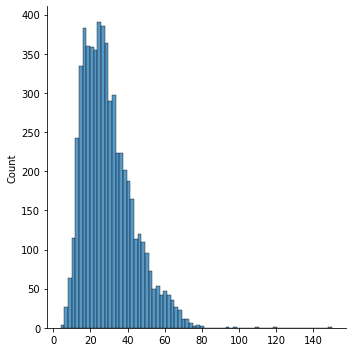

In [10]:
# check the token length distribution
token_lens = []
for txt in df.Sentence:
    token_lens.append(len(tokenizer.encode(txt, max_length=512)))

sns.displot(token_lens)

In [11]:
# divide data into train (50%), val (10%), test (10%)
X_train, X_val_test, y_train, y_val_test = train_test_split(df.Sentence.values, labels, test_size=.2, random_state=RANDOM_SEED)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=.5, random_state=RANDOM_SEED)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((4673,), (4673,), (584,), (584,), (585,), (585,))

In [12]:
# set parameter
MAX_LEN = 50
BATCH_SIZE = 16
device = torch.device('cuda')
lr_rate = 2e-5
EPOCH = 5
num_classes = 3

In [13]:
# create dataset
class FinancialDataset(Dataset):
    def __init__(self, sentences, target, tokenizer, max_len):
        self.sentences = sentences
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.sentences)
    def __getitem__(self,idx):
        sentence = self.sentences[idx]
        # encode input sentence
        encoding = tokenizer.encode_plus(
            sentence,
            max_length=self.max_len,
            add_special_tokens=True,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )
        return {
            'input_ids': torch.squeeze(encoding['input_ids'],dim=0),
            'attention_mask': torch.squeeze(encoding['attention_mask'],dim=0),
            'targets': torch.tensor(self.target[idx],dtype=torch.long)
        }

In [14]:
# create dataloader
train_dataset = FinancialDataset(X_train, y_train, tokenizer, MAX_LEN)
train_dataloader = DataLoader(train_dataset,
                             batch_size=BATCH_SIZE,
                             num_workers=2)

val_dataset = FinancialDataset(X_val, y_val, tokenizer, MAX_LEN)
val_dataloader = DataLoader(val_dataset,
                             batch_size=BATCH_SIZE,
                             num_workers=2)

test_dataset = FinancialDataset(X_test, y_test, tokenizer, MAX_LEN)

In [15]:
# check the output of dataloader
next(iter(train_dataset))

{'input_ids': tensor([  101,  1996,  2723,  2181,  1997,  1996,  1061, 12798, 18136,  2669,
          6657,  2638,  2622,  2097,  2022,  1021,  1010,  7706,  5490,  1049,
          5594,  1010,  6021,  2692,  5490,  3027,  1998,  1996,  2311,  1005,
          1055,  7977,  2181,  2097,  2561,  2260,  1010,  5385,  5490,  1049,
          1012,  1037,  2561,  2423,  1012,  1015,  1003,  1997,  1996,   102]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1]),
 'targets': tensor(1)}

In [16]:
# create classifier
class SentimentClassifier(nn.Module):
    def __init__(self,n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.softmax = nn.Softmax(dim=1)
    def forward(self,input_ids, attention_mask):
        _, pooled_output = self.bert(input_ids=input_ids,attention_mask=attention_mask,return_dict = False)
        output = self.drop(pooled_output)
        output = self.out(output)
        return self.softmax(output)

In [17]:
# function to calculate average 
class Metrics(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.loss, self.acc = 0, 0
        self.avg_loss, self.avg_acc = 0, 0
        self.sum_loss, self.sum_acc = 0, 0
        self.count = 0

    def update(self, loss, acc, n=1):
        self.loss, self.acc = loss, acc
        self.sum_loss += loss * n
        self.sum_acc += acc * n
        self.count += n
        self.avg_loss, self.avg_acc = self.sum_loss / self.count, self.sum_acc / self.count

# function to calculate accuracy
def check_acc(preds, labels):
    correct = 0
    for pred, label in zip(preds, labels):
        if pred == label:
            correct += 1
    return correct/len(preds)

# function to record loss & accuracy
class Log(object):
    def __init__(self):
        self.train_accuracy = []
        self.train_loss = []
        self.val_accuracy = []
        self.val_loss = []
    def append(self, train, val):
        self.train_loss.append(train.avg_loss)
        self.train_accuracy.append(train.avg_acc)
        self.val_loss.append(val.avg_loss)
        self.val_accuracy.append(val.avg_acc)

In [18]:
# train function
def train_fn(data_loader, model, optimizer, criterion,device, epoch):
    model.train()
    
    metrics = Metrics()
    tk0 = tqdm(data_loader, total=len(data_loader))
    for step, inputs in enumerate(tk0):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        targets = inputs['targets']
        input_ids = input_ids.to(device, non_blocking=True).long()
        attention_mask = attention_mask.to(device, non_blocking=True).long()
        targets = targets.to(device, non_blocking=True).long()
        
        # make prediction
        outputs = model(input_ids=input_ids,
                       attention_mask=attention_mask)
        # calculate loss
        loss = criterion(outputs, targets)
        preds = torch.argmax(outputs,dim=1)
        accuracy = check_acc(preds,targets)
        
        # update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # save loss value
        metrics.update(loss.item(),accuracy, BATCH_SIZE)
        tk0.set_postfix(loss=metrics.avg_loss,accuracy=metrics.avg_acc, epoch=epoch+1)
    return metrics

# val function
def eval_fn(data_loader, model,criterion,device, epoch):
    model.eval()
    
    metrics = Metrics()
    tk0 = tqdm(data_loader, total=len(data_loader))
    for step, inputs in enumerate(tk0):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        targets = inputs['targets']
        input_ids = input_ids.to(device, non_blocking=True).long()
        attention_mask = attention_mask.to(device, non_blocking=True).long()
        targets = targets.to(device, non_blocking=True).long()
        
        # make prediction
        outputs = model(input_ids=input_ids,
                       attention_mask=attention_mask)
        # calculate loss
        loss = criterion(outputs, targets)
        preds = torch.argmax(outputs,dim=1)
        accuracy = check_acc(preds,targets)
        
        # save loss value
        metrics.update(loss.item(),accuracy, BATCH_SIZE)
        tk0.set_postfix(loss=metrics.avg_loss,accuracy=metrics.avg_acc, epoch=epoch+1)
    return metrics

In [19]:
def run():
    # Load pretrained model
    model = SentimentClassifier(num_classes)
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(),lr=lr_rate)
    # Set loss function
    criterion = nn.CrossEntropyLoss()
    scheduler = ReduceLROnPlateau(optimizer, 'min')
    best_loss = 10**5
    log = Log()
    for epoch in range(0,EPOCH):
        train_metrics = train_fn(train_dataloader, model, optimizer, criterion, device, epoch)
        val_metrics = eval_fn(val_dataloader, model, criterion, device, epoch)
        log.append(train_metrics,val_metrics)
        scheduler.step(val_metrics.avg_loss)
        # Check if val_loss is less than best_loss
        if val_metrics.avg_loss < best_loss:
            # Update best loss
            best_loss = val_metrics.avg_loss
            # Save model
            torch.save(model.state_dict(), f'best.pth')
    return log

In [20]:
log = run()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 37/37 [00:01<00:00, 19.11it/s, accuracy=0.78, epoch=5, loss=0.759] 


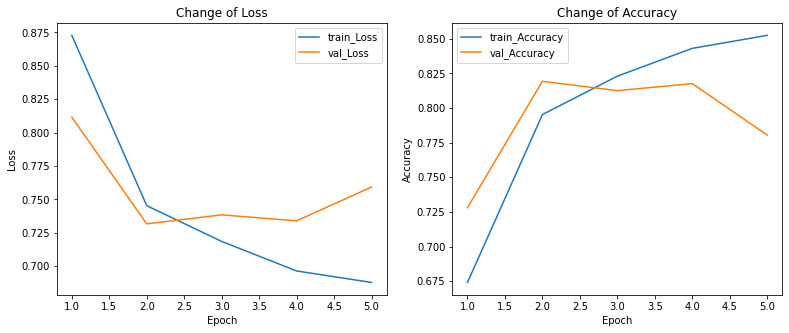

In [21]:
fig, axs = plt.subplots(1,2,figsize=(13,5))

def plot_log(ax, train_value, val_value, label):
    sns.lineplot(y=train_value,x=range(1,EPOCH+1),ax=ax,label=f'train_{label}')
    sns.lineplot(y=val_value,x=range(1,EPOCH+1),ax=ax,label=f'val_{label}')
    ax.set_title(f'Change of {label}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(label)
    
plot_log(axs[0],log.train_loss,log.val_loss,'Loss')
plot_log(axs[1],log.train_accuracy,log.val_accuracy,'Accuracy')

In [22]:
# load weight with best val loss
model = SentimentClassifier(num_classes)
model.load_state_dict(torch.load('./best.pth'))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [23]:
# test function
def test_fn(dataset, model, device):
    model = model.to(device)
    model.eval()
    
    labels = []
    predictions = []
    tk0 = tqdm(dataset, total=len(dataset))
    for step, inputs in enumerate(tk0):
        input_ids = torch.unsqueeze(inputs['input_ids'],dim=0)
        attention_mask = torch.unsqueeze(inputs['attention_mask'],dim=0)
        targets = torch.unsqueeze(inputs['targets'],dim=0)
        input_ids = input_ids.to(device, non_blocking=True).long()
        attention_mask = attention_mask.to(device, non_blocking=True).long()
        targets = targets.to(device, non_blocking=True).long()
        # make prediction
        outputs = model(input_ids=input_ids,
                       attention_mask=attention_mask)
        pred = torch.argmax(torch.softmax(outputs, dim=1),dim=1)
        
        labels.append(targets.item())
        predictions.append(pred.item())
    return labels, predictions

In [24]:
# predict test dataset
labels, preds = test_fn(test_dataset, model, device)

100%|██████████| 585/585 [00:09<00:00, 58.54it/s]


In [25]:
print(f'Label\t\t:{labels[:10]}')
print(f'Prediction\t:{preds[:10]}')

Label		:[1, 0, 2, 2, 2, 1, 0, 1, 2, 1]
Prediction	:[1, 1, 1, 1, 2, 1, 1, 1, 2, 1]


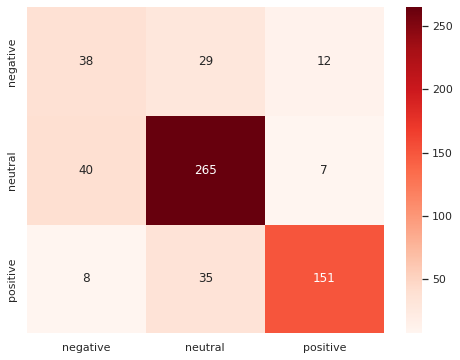

In [26]:
# visualize predictions
sns.set_theme(style='whitegrid',rc={'figure.figsize':(8,6)})
cf_matrix = confusion_matrix(labels, preds)
sns.heatmap(cf_matrix,annot=True,cmap='Reds',fmt="g",xticklabels=encoder.classes_,yticklabels=encoder.classes_);

In [27]:
label_preds = encoder.inverse_transform(preds)
label_targets = encoder.inverse_transform(labels)

In [28]:
print(classification_report(label_targets,label_preds))


              precision    recall  f1-score   support

    negative       0.44      0.48      0.46        79
     neutral       0.81      0.85      0.83       312
    positive       0.89      0.78      0.83       194

    accuracy                           0.78       585
   macro avg       0.71      0.70      0.71       585
weighted avg       0.78      0.78      0.78       585

